## Подгрузка библиотек

In [80]:
import aiohttp
import asyncio
import pandas as pd
from IPython import display
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Создание класса для сбора данных

Для сбора данных за основу был взят класс, который был представлен в baseline ноутбуке. Он использовался для сбора данных с сайта Lenta.ru. Однако в ходе использования данного класса было замечено, что он имеет ряд проблем.

- Этот класс довольно медленно медленно собирал данные. Поэтому был в класс был интегрирован асинхронный подход. Это позволило выполнять несколько запросов на сайт одновременно, что значительно ускорило сбор.
- В ходе сбора данных довольно часто возникала ошибка `ChunkedEncodingError: Response ended prematurely`, что прерывало работу парсера. Поэтому в однин из методов этого класса `_fetch_with_retries` была вшита обработка таких ошибок, чтобы сделать работу парсера более гладкой.
- Также было замечено, что данные иногда не с первого раза собираются с помощью запросов. По этому в метод класса `_fetch_with_retries` также был вшит цикл, в котором дается 5 попыток на запрос данных, что позволило собрать больше данных для обучения моделей.
- Дополнительно формат сохранения данных был сменен на csv формат.

In [ ]:
class LentaRuParser:
    def __init__(self):
        pass

    def _get_url(self, param_dict: dict) -> str:
        """
        Генерирует URL для запроса статей.
        """
        has_type = int(param_dict['type']) != 0
        has_bloc = int(param_dict['bloc']) != 0

        url = (
            'https://lenta.ru/search/v2/process?'
            + f'from={param_dict["from"]}&'
            + f'size={param_dict["size"]}&'
            + f'sort={param_dict["sort"]}&'
            + f'title_only={param_dict["title_only"]}&'
            + f'domain={param_dict["domain"]}&'
            + 'modified%2Cformat=yyyy-MM-dd&'
            + (f'type={param_dict["type"]}&' if has_type else '')
            + (f'bloc={param_dict["bloc"]}&' if has_bloc else '')
            + f'modified%2Cfrom={param_dict["dateFrom"]}&'
            + f'modified%2Cto={param_dict["dateTo"]}&'
            + f'query={param_dict["query"]}'
        )
        return url

    async def _fetch_with_retries(self, session, url, max_retries=5):
        """
        Асинхронно выполняет запрос с повторными попытками.
        Пропускает данные после 5 неудачных попыток.
        """
        for attempt in range(max_retries):
            try:
                async with session.get(url, timeout=aiohttp.ClientTimeout(total=20)) as response:
                    response.raise_for_status()  # Проверяем код ответа
                    return await response.json()
            except aiohttp.ClientPayloadError:
                print(f"ChunkedEncodingError, попытка {attempt + 1}/{max_retries}")
            except aiohttp.ClientError as e:
                print(f"Ошибка: {e}, попытка {attempt + 1}/{max_retries}")
            await asyncio.sleep(3)  # Ожидание между попытками

        print(f"Пропуск данных для URL: {url}")
        return None  # Возвращаем None при неудаче

    async def _get_search_table(self, session, param_dict: dict) -> pd.DataFrame:
        """
        Асинхронно получает таблицу статей.
        """
        url = self._get_url(param_dict)
        data = await self._fetch_with_retries(session, url)
        
        if not data or 'matches' not in data:
            print(f"Некорректный ответ или отсутствие поля 'matches'. URL: {url}")
            return pd.DataFrame()  # Возвращаем пустой DataFrame, если данные отсутствуют
        
        return pd.DataFrame(data['matches'])

    async def get_articles(self, param_dict, time_step=37, save_every=5, save_csv=True):
        """
        Асинхронно загружает статьи, разделяя запросы по временным интервалам.
        """
        time_step = timedelta(days=time_step)
        date_from = datetime.strptime(param_dict['dateFrom'], '%Y-%m-%d')
        date_to = datetime.strptime(param_dict['dateTo'], '%Y-%m-%d')

        if date_from > date_to:
            raise ValueError('dateFrom должно быть меньше dateTo')

        tasks = []
        save_counter = 0
        out_list = []

        async with aiohttp.ClientSession() as session:
            while date_from <= date_to:
                # Устанавливаем текущий интервал
                current_to = min(date_from + time_step, date_to)
                param_copy = param_dict.copy()
                param_copy['dateFrom'] = date_from.strftime('%Y-%m-%d')
                param_copy['dateTo'] = current_to.strftime('%Y-%m-%d')

                print(f'Парсинг статей с {param_copy["dateFrom"]} по {param_copy["dateTo"]}')
                tasks.append(self._get_search_table(session, param_copy))

                date_from = current_to + timedelta(days=1)
                save_counter += 1

                if save_counter == save_every:
                    # Сохраняем промежуточный результат
                    display.clear_output(wait=True)
                    results = await asyncio.gather(*tasks)
                    out_list.extend([res for res in results if not res.empty])  # Пропускаем пустые DataFrame
                    pd.concat(out_list, ignore_index=True).to_csv("checkpoint_table.csv")
                    print("Checkpoint сохранён!")
                    tasks = []
                    save_counter = 0

            # Обрабатываем оставшиеся задачи
            results = await asyncio.gather(*tasks)
            out_list.extend([res for res in results if not res.empty])  # Пропускаем пустые DataFrame

        final_df = pd.concat(out_list, ignore_index=True)

        if save_csv:
            final_df.to_csv(f"lenta_{param_dict['dateFrom']}_{param_dict['dateTo']}.csv", index=False)
        print("Загрузка завершена!")

        return final_df

В ходе парсинга данные собирались с интервалом в 1 день, так как запросы с большим интервалом довольно часто работали не корректно. Данные были собраны за интервал с `2023-01-01 - 2024-12-20`

In [ ]:
query = ''
offset = 0
size = 1000
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "0" # topic = тематика новости
dateFrom = '2023-01-01'
dateTo = "2024-12-20"

param_dict = {'query'     : query,
              'from'      : str(offset),
              'size'      : str(size),
              'dateFrom'  : dateFrom,
              'dateTo'    : dateTo,
              'sort'      : sort,
              'title_only': title_only,
              'type'      : material,
              'bloc'      : bloc,
              'domain'    : domain}

print("param_dict:", param_dict)

In [ ]:
nest_asyncio.apply()

parser = LentaRuParser()

async def main():
    df = await parser.get_articles(param_dict=param_dict,
                                   time_step = 1,
                                   save_every = 5)
    return df

In [ ]:
df = asyncio.run(main())
print("Размер полученного DataFrame:", df.shape)

In [ ]:
df.to_csv('lenta_all_news_2324.csv')

## Полученные данные

Данные были собраны еще на этапе чернового ноутбука. Поэтому они будут просто загружены, чтобы не тратить на это время в ходе оформления этого ноутбука.

In [11]:
df = pd.read_csv('lenta_all_news_2324.csv')

In [13]:
df.head()

,docid,url,title,modified,lastmodtime,type,domain,status,part,bloc,tags,image_url,pubdate,text,rightcol,snippet
0,1363803,https://lenta.ru/news/2023/01/01/exponenta/,Ким Чен Ын пообещал нарастить производство яде...,1672531825,1672531825,1,1,0,0,2,[1],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672531825,Фото: ЦТАК / Reuters Марина Совина Лидер КНДР ...,Ким Чен Ын пообещал нарастить производство яде...,Фото: ЦТАК / Reuters Марина Совина Лидер ... я...
1,1363805,https://lenta.ru/news/2023/01/01/yaroslavl/,В российском городе пропал ребенок,1672532081,1672532081,1,1,0,0,1,[4],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672532081,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,В российском городе пропал ребенок,Фото: Кирилл Шипицин / РИА Новости ... мальчик...
2,1363807,https://lenta.ru/news/2023/01/01/alco/,Россиянам рассказали о влиянии алкоголя на сон,1672533004,1672533004,1,1,0,0,1,[2],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672533004,Фото: Pixabay Марина Совина Терапевт Ирина Анд...,Россиянам рассказали о влиянии алкоголя на сон,Фото: Pixabay Марина Совина Терапевт ... употр...
3,1363808,https://lenta.ru/news/2023/01/01/ded_moroz/,Подсчитана пенсия Деда Мороза,1672533251,1672533252,1,1,0,1,1,[2],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672533251,Фото: Илья Наймушин/ РИА Новости Марина Совина...,Подсчитана пенсия Деда Мороза,Фото: Илья Наймушин/ РИА Новости Марина ... Ги...
4,1363806,https://lenta.ru/news/2023/01/01/anomalia_/,Климатолог предупредил о возможных погодных ан...,1672533531,1672533531,1,1,0,0,12,[281],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672533531,Фото: Komsomolskaya Pravda / Global Look Press...,Климатолог предупредил о возможных погодных ан...,Фото: Komsomolskaya Pravda / Global Look ... К...


Как можно заметить в ходе сбора данных парсер просто считыват запрошенные данные в виде `json`, что приводит к тому, что собирается довольно много лишних данных.

In [16]:
df.describe()

,docid,modified,lastmodtime,type,domain,status,part,bloc,pubdate
count,1.184150e+05,1.184150e+05,1.184150e+05,118415.000000,118415.0,118415.0,118415.000000,118415.000000,1.184150e+05
mean,1.550570e+06,1.703680e+09,1.703776e+09,1.480547,1.0,0.0,0.293299,11.047722,1.703680e+09
std,1.066601e+05,1.721523e+07,1.722732e+07,2.605464,0.0,0.0,1.080775,18.760676,1.721523e+07
min,1.006656e+06,1.672532e+09,1.672532e+09,1.000000,1.0,0.0,0.000000,0.000000,1.672532e+09
25%,1.455868e+06,1.688335e+09,1.688379e+09,1.000000,1.0,0.0,0.000000,2.000000,1.688335e+09
50%,1.554821e+06,1.705063e+09,1.705078e+09,1.000000,1.0,0.0,0.000000,3.000000,1.705063e+09
75%,1.637826e+06,1.717949e+09,1.719058e+09,1.000000,1.0,0.0,0.000000,8.000000,1.717949e+09
max,1.745612e+06,1.733702e+09,1.734692e+09,17.000000,1.0,0.0,7.000000,87.000000,1.733702e+09


Всего было собрано 118415 строк данных. Однако информация о блоках новостей немного не сходится с категориями из соревнования. Поэтому дополнительно пришлось изучить отдельные новости, чтобы выявить их. Было получено следующее соотношение:

* 'Общество/Россия' : 0 - 1
* 'Экономика' : 1 - 4
* 'Силовые структуры' : 2 - 37
* 'Бывший СССР' : 3 - 3
* 'Спорт' : 4 - 8 
* 'Забота о себе' : 5 - 87
* 'Строительство' : 6 - в ходе исследования собранного набора данных было выявлено, что категории строительства наиболее соответстует категория экономика с тегами 388 и 389, которые соответствуют подразделам городской среды и недвижимости. Стоит отметить, что отдельной такой категории на новостном портале lenta.ru не присутствует.
* 'Туризм/Путешествия' : 7 - 48
* 'Наука и техника' : 8 - 5


In [22]:
df = df[df.bloc.isin([1, 4, 37, 3, 8, 87, 48, 5])]
TagsMap = {1 : 0, 3 : 3, 4 : 1, 5 : 8, 8 : 4, 37 : 2, 48 : 7, 87 : 5}
df['topic'] = df['bloc'].map(TagsMap)
df.loc[((df.topic == 1)&((df.tags == '[388]')|(df.tags == '[389]'))), 'topic'] = 6

In [28]:
df['topic'].value_counts(normalize=True).to_frame()

,proportion
topic,
0,0.308638
3,0.201533
4,0.114107
1,0.110486
2,0.109532
8,0.059805
7,0.046730
5,0.034849
6,0.014321


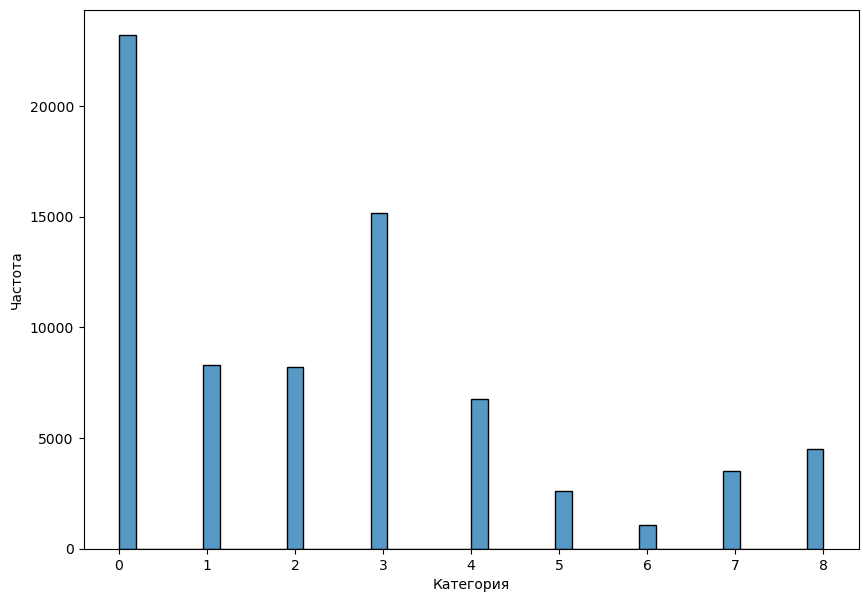

In [74]:
plt.figure(figsize=(10, 7))
sns.histplot(data = df, x = 'topic')
plt.ylabel('Частота')
plt.xlabel('Категория')
plt.show()

В собранном наборе данных наиболее многочисленными категориями новостей являются новсоти связанные с обществом (30%) и бывшим СССР (20%), а самыми малочисленными являются новости связанные с заботой о себе (3.5%) и строительством (1.4%). Иcходя из этого, а также из долей других классов в наборе данных, можно сказать, что в ходе обучения моделей придется столкнуться с дисбалансом классов.

В данных есть довольно много стобцов с данными, которые не являются особо полезными. Поэтому для дальнейшего рассмотрения данных стоит их вырезать.

In [34]:
df = df.copy().drop(columns = ['docid', 'url', 'title', 'modified', 'lastmodtime', 'type',
                  'domain','status', 'part', 'bloc', 'tags', 'image_url', 'pubdate',
                  'rightcol', 'snippet'])

In [36]:
df.head()

,text,topic
1,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,0
2,Фото: Pixabay Марина Совина Терапевт Ирина Анд...,0
3,Фото: Илья Наймушин/ РИА Новости Марина Совина...,0
5,Фото: Валерий Мельников / РИА Новости Марина С...,0
6,Леонид Пасечник Фото: Alexei Nikolsky / Global...,0


## Очистка данных

### Дубликаты и N/A значения

Исследуем набор данных на наличие дубликатов новостей

In [43]:
df.duplicated().sum()

2053

In [45]:
df[df.duplicated()]

,text,topic
49,NaN,4
50,NaN,4
51,NaN,4
52,NaN,4
192,NaN,4
...,...,...
118150,NaN,4
118151,NaN,4
118152,NaN,4
118153,NaN,4


Как можно заметить повторяющиеся значения в основном являются пустыми значениями. Стоит проверить есть ли не пустые значения среди дубликатов. Но для этого для начала стоит избавиться от пропусков.

In [50]:
df.isna().sum()

text     2062
topic       0
dtype: int64

In [53]:
df = df.dropna(subset='text')

In [56]:
df.duplicated().sum()

0

Судя по всему все повторяющиеся значения в наборе данных были пропусками, так как после их удаления дубликатов не осталось.

### Выбросы в данных

Весьма вероятно, что в данных присутствуют различные аномалии, которые могут помешать дальнейшему обучению моделей. Поэтому с этим стоит разобраться.

In [63]:
df['text_len'] = df.text.apply(len)

/var/folders/2_/v0zbbryd5nl_rj_zp5vsx3200000gn/T/ipykernel_68514/3156348124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df.text.apply(len)


In [67]:
df.describe()

,topic,text_len
count,73350.000000,73350.000000
mean,2.418541,1337.793920
std,2.395737,1606.046683
min,0.000000,1.000000
25%,0.000000,846.000000
50%,2.000000,1018.000000
75%,4.000000,1309.000000
max,8.000000,42279.000000


Как можно заметить в данных есть как новости с аномально низкой длинной, так и с аномально высокой. Возможно стоит рассмотреть график распредления длинны.

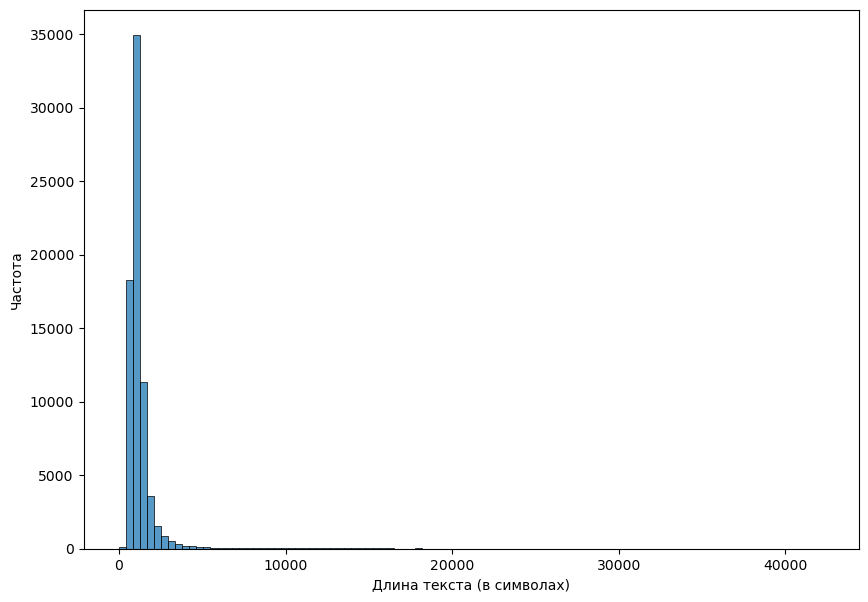

In [78]:
plt.figure(figsize=(10, 7))
sns.histplot(data = df, x = 'text_len',bins=100)
plt.ylabel('Частота')
plt.xlabel('Длина текста (в символах)')
plt.show()

Как можно заметить в данных довольно много выбросов с большой длиной текста. Вероятно это связано с тем, что в данных помимо небольших новостей, присутствуют довольно-таки большие статьи. Наверное, это не станет большой проблемой в ходе обучения моделей. Однако черзмерно короткие новости имеют довольно-таки низкую значимость в ходе обучения поэтому от таких новостей стоило бы избавиться. Избавляться от выбросов будем с помощью интерквантильного размаха.

In [84]:
def calculate_outlier_bounds(data):
    Q1 = np.percentile(data, 25)  
    Q3 = np.percentile(data, 75)  
    IQR = Q3 - Q1 

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [86]:
lb, ub = calculate_outlier_bounds(df.text_len)

In [89]:
df = df[(df.text_len > lb)]

## Подробное рассмотрение данных

Для лучшего понимания стоит рассмотреть то, насколько отличаются новости по категориям. Для этого рассмотрим примеры новостей, а также облака слов.

### Общество/Россия - 0

In [193]:
df.reset_index(inplace=True, drop=True)

#### Пример новостей

In [196]:
for i in df[df.topic == 0].index[:5]:
    print(f'{i}. {df[df.topic == 0].text[i]} \n')

0. Фото: Кирилл Шипицин / РИА Новости Марина Совина В Ярославле вечером 31 декабря пропал восьмилетний мальчик, не вернувшись с прогулки. Об этом сообщил портал 76.ru. Инцидент произошел в Заволжском районе. Об этом сообщает портал 76.ru. Сейчас его ищет полиция и близкие. Информации о других обстоятельствах исчезновения — нет. Ребенок был одет в черную шапку с белой полосой, черное пальто и брюки, на ногах у него были черно-серые ботинки. Ранее в Калининске Саратовской области в лесополосе нашли тело младенца. По данным СК, жительница города обратилась в правоохранительные органы с просьбой проверить 37-летнюю россиянку, которая была беременна, но через некоторое время признаки ее беременности пропали. 

1. Фото: Pixabay Марина Совина Терапевт Ирина Андреева в беседе с «Медик Форум» предупредила россиян о негативном влиянии чрезмерного употребления алкоголя на сон. По ее словам, многие используют спиртное в качестве снотворного, что является большой ошибкой. «При употреблении алкоголя

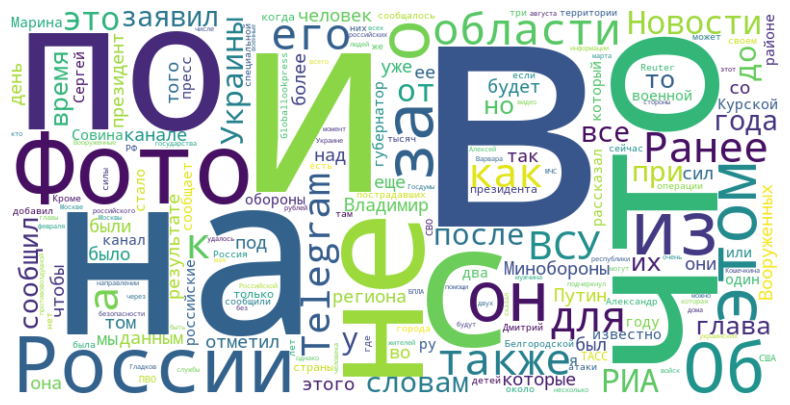

In [123]:
text_data_0 = " ".join(df[df.topic == 0]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_0)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Экономика - 1

In [159]:
for i in df[df.topic == 1].index[:5]:
    print(f'{i}. {df[df.topic == 1].text[i]} \n')

9. Фото: Михаил Воскресенский / РИА Новости Марина Совина Банк России с 1 января 2023 года ввел для банков с универсальной лицензией и микрофинансовых организаций (МФО) количественные ограничения на выдачу необеспеченных потребкредитов населению. Об этом сообщается на сайте регулятора. Теперь доля кредитов с показателем долговой нагрузки заемщика выше 80 процентов не должна превышать 25 процентов объема выдачи или 35 процентов займов для микрофинансовых организаций. Предельно допустимая доля необеспеченных потребкредитов на срок более пяти лет ограничена планкой в 10 процентов. В ЦБ выразили обеспокоенность тем, что необеспеченное потребительское кредитование растет устойчиво высокими темпами. Дальнейший же рост закредитованности граждан «в условиях структурной перестройки экономики может создавать дополнительные макроэкономические риски», предупредил регулятор. Принятая мера направлена на ограничение роста закредитованности граждан за счет дестимулирования кредитования заемщиков с выс

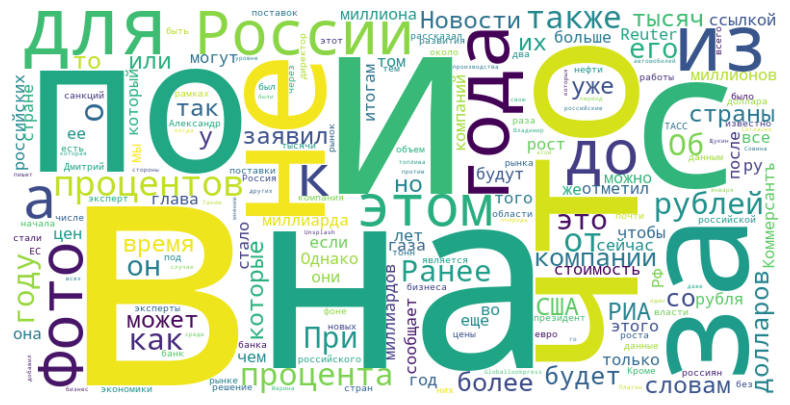

In [135]:
text_data_1 = " ".join(df[df.topic == 1]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Силовые структуры - 2

In [163]:
for i in df[df.topic == 2].index[:5]:
    print(f'{i}. {df[df.topic == 2].text[i]} \n')

52. Фото: Евгений Одиноков / РИА Новости Варвара Кошечкина Новогодняя ночь прошла в России без происшествий. Об этом заявила официальный представитель Министерства внутренних дел (МВД) Ирина Волк, пишет «Интерфакс». По ее словам, полицейские обеспечили безопасность и общественный порядок в новогоднюю ночь. В мероприятиях приняли участие более 1,6 миллиона человек. Дежурство осуществляли 66 тысяч сотрудников правоохранительных органов. Ранее стало известно, что в Барнауле фейерверк «расстрелял» людей. Инцидент произошел на Павловском тракте. Залпы фейерверка также попали в стоявшие рядом автомобили. По предварительным данным, в результате случившегося никто не пострадал. 

67. Фото: Екатерина Якель / «Лента.ру» Варвара Кошечкина Водитель каршеринга в состоянии алкогольного опьянения сбил женщину с детьми под Петербургом. Об этом пишет MK.RU со ссылкой на пресс-службу МВД России по Санкт-Петербургу и Ленинградской области. Авария произошла в воскресенье, 1 января около 08:50 мск во дворе

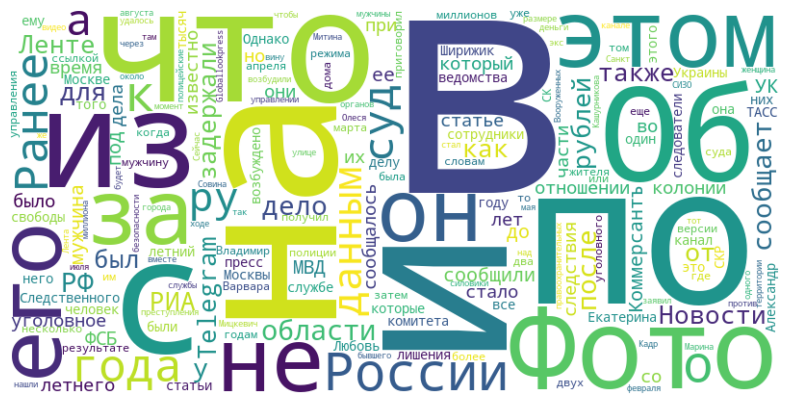

In [144]:
text_data_2 = " ".join(df[df.topic == 2]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_2)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Бывший СССР - 3

In [155]:
for i in df[df.topic == 3].index[:5]:
    print(f'{i}. {df[df.topic == 3].text[i]} \n')

33. Фото: Gleb Garanich / Reuters Варвара Кошечкина В Киевской области в ночь на воскресенье, 1 января, был поражен объект инфраструктуры. Об этом заявил глава киевской облгосадминистрации Алексей Кулеба в Telegram. «Есть повреждение объекта инфраструктуры», — сообщил он. Кулеба добавил, что на месте до утра работали представители украинских экстренных служб. Пострадавших в результате случившегося, по предварительным данным, нет. В новогоднюю ночь на всей территории Украины была объявлена воздушная тревога. Сигнал прозвучал во всех областях страны. 31 декабря прошлого года в Днепропетровске и Николаевской областях были слышны взрывы, работала система противовоздушной обороны. На некоторых территориях начались экстренные отключения электроэнергии. 

39. Фото: Евгений Биятов / РИА Новости Варвара Кошечкина Вооруженные силы России уничтожили базу элитного украинского спецназа в Хмельницком. Речь идет об объекте 8-го полка Сил специальных операций (ССО) Украины, который считается лучшим фо

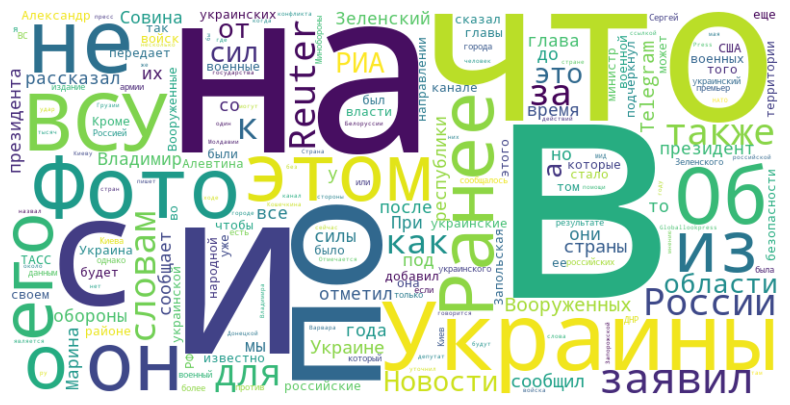

In [165]:
text_data_3 = " ".join(df[df.topic == 3]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_3)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

'Общество/Россия' : 0 - 1
'Экономика' : 1 - 4
'Силовые структуры' : 2 - 37
'Бывший СССР' : 3 - 3
'Спорт' : 4 - 8
'Забота о себе' : 5 - 87
'Строительство' : 6 - в ходе исследования собранного набора данных было выявлено, что категории строительства наиболее соответстует категория экономика с тегами 388 и 389, которые соответствуют подразделам городской среды и недвижимости. Стоит отметить, что отдельной такой категории на новостном портале lenta.ru не присутствует.
'Туризм/Путешествия' : 7 - 48
'Наука и техника' : 8 - 5

### Спорт - 4

In [168]:
for i in df[df.topic == 4].index[:5]:
    print(f'{i}. {df[df.topic == 4].text[i]} \n')

8. Фото: Geoff Burke-USA TODAY Sports / Reuters Марина Совина Российский нападающий «Вашингтон Кэпиталс» Александр Овечкин забросил три шайбы в матче регулярного чемпионата НХЛ против «Монреаль Канадиенс». Об этом сообщается на сайте лиги. Россиянин оформил 30-й хет-трик в своей карьере. После этого матча на счету Овечкина 806 голов в НХЛ. Он сократил до 89 голов отставание от канадца Уэйна Гретцки, занимающего первую строчку в списке лучших снайперов в чемпионатах НХЛ за всю историю (894 заброшенные шайбы). Овечкин вышел на второе место в списке лучших снайперов в ночь на 24 декабря, оформив дубль в матче против «Виннипег Джетс». Ранее Овечкин высказался о погоне за рекордом Гретцки. Он заявил, что его ждет долгий путь на пути к достижению канадца. Овечкин выступает за «Кэпиталс» с 2005 года. Вместе с клубом он выигрывал Кубок Стэнли в 2018-м. 

34. Михаил Сергачев Фото: Nick Turchiaro / USA Today Sports / Reuters Ксения Курашкина «Тампа-Бэй Лайтнинг» обыграла «Аризону Койотс» в матче

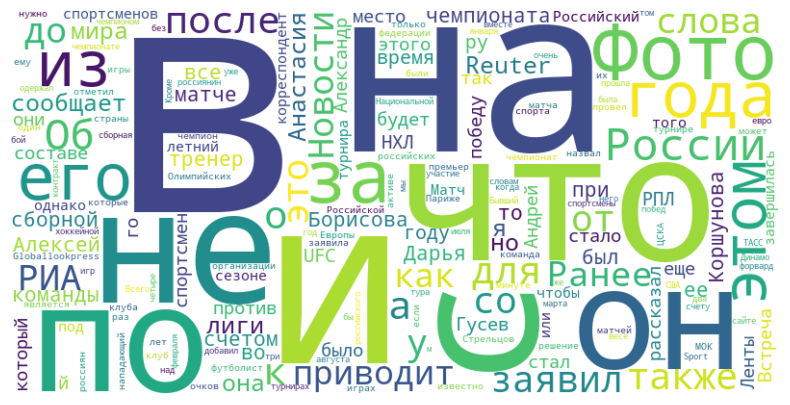

In [170]:
text_data_4 = " ".join(df[df.topic == 4]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_4)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Забота о себе - 5

In [173]:
for i in df[df.topic == 5].index[:5]:
    print(f'{i}. {df[df.topic == 5].text[i]} \n')

12. Фото: Shutterstock Екатерина Смирная Зимой кожа нуждается в особенном уходе, потому что низкая температура и холодный ветер повреждают ее, рассказала врач-дерматовенеролог, косметолог Анна Михайлова. В беседе с «Лентой.ру» она поделилась пятью советами по уходу за кожей в это время года. По словам врача, на морозе происходит спазм мелких сосудов. В норме они доставляют кровь ко всем слоям кожи. А если нарушается кровоснабжение, то нарушается и жизнедеятельность клеток кожи. Кроме того, на холоде иначе работают сальные железы. Кожного сала выделяется меньше, и его недостаток изменяет состав водно-липидной мантии, поделилась Михайлова. Так, кожа становится более уязвимой к раздражителям. Уход за кожей в зимнее время заключается в ее защите, так как нужно максимально снизить воздействие повреждающего фактора, объяснила косметолог. «Во-первых, защищайте кожу воротником, капюшоном, шарфом, перчатками. Особенно в ветряную погоду. Потому что снег и ветер работают как пилинг, и даже грубее

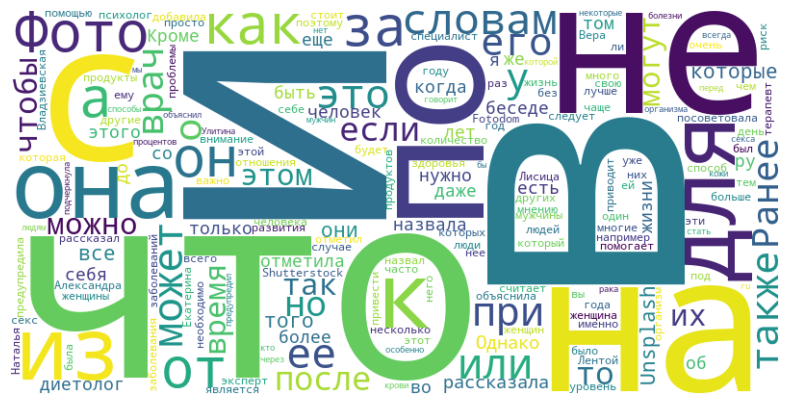

In [175]:
text_data_5 = " ".join(df[df.topic == 5]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_5)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Строительство - 6

In [178]:
for i in df[df.topic == 6].index[:5]:
    print(f'{i}. {df[df.topic == 6].text[i]} \n')

44807. Фото: Unsplash Александра Качан Чистящие средства с абразивными элементами могут испортить пластиковый подоконник. От ряда ошибок при уборке домохозяек предостерегли эксперты издания «БелНовости». По словам специалистов, бытовая химия с абразивными элементами способна повредить верхний слой подоконника, после чего не получится вернуть ему гладкость и белый цвет. Также для мытья подоконника не подойдут средства с химически активными веществами, жесткие щетки и меламиновая губка. Вместо этого рекомендуется убирать загрязнения с помощью мыльной воды на основе тертого хозяйственного мыла или раствора соды и стирального порошка. Можно также использовать уксус и соду, но смесь нельзя оставлять на пластике надолго. Ранее эксперты портала рассказали о необычных способах применить лимон в хозяйства. К примеру, фруктом можно эффективно очистить разделочную доску. 

44835. Фото: Александр Гальперин / РИА Новости Маргарита Пименова Депутат Государственной Думы и председатель Союза дачников 

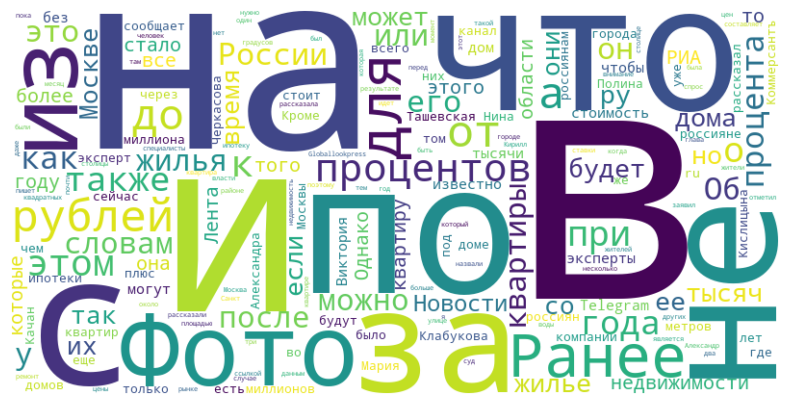

In [180]:
text_data_6 = " ".join(df[df.topic == 6]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_6)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Туризм/Путешествия - 7

In [183]:
for i in df[df.topic == 7].index[:5]:
    print(f'{i}. {df[df.topic == 7].text[i]} \n')

29. Фото: Александр Гальперин / РИА Новости Варвара Кошечкина В России пассажиры верхних полок поездов получат право законно размещаться на нижних в некоторых случаях. О том, что в споре между путешественниками в 2023 году поставят точку, сообщает РИА Новости. Известно, что туристы с верхних полок смогут сидеть на нижних местах у столика для приема пищи во время завтрака, обеда и ужина — с 7:00 до 10:00, с 12:00 до 15:00 и с 19:00 до 21:00. Для этого им будет отведено полчаса утром и вечером, а также час днем. Предположительно данные правила вступят в силу осенью текущего года. Ранее законодательно указанные меры закреплены не были. Минтранс принял соответствующее решение в связи с многочисленными жалобами пассажиров. 21 ноября сообщалось, что россияне также захотели поставить точку в споре о подлокотниках в самолетах. По их словам, новый закон поможет избежать конфликтов и разногласий. 

77. Фото:  Evgenii Bugubaev / Anadolu Agency via Getty Images Варвара Кошечкина Москва, Сочи и Тур

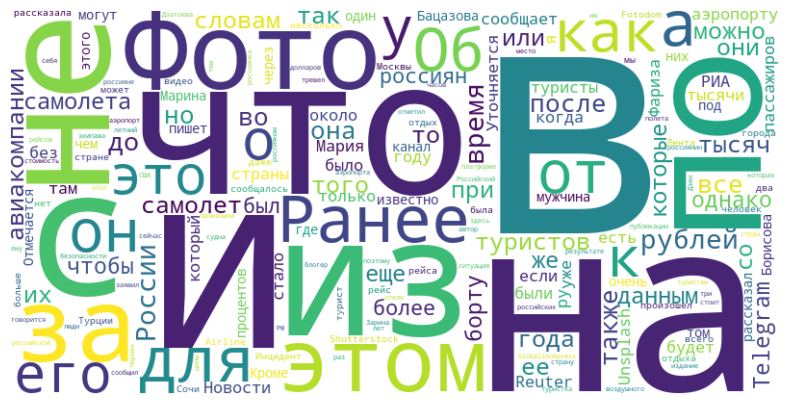

In [185]:
text_data_7 = " ".join(df[df.topic == 7]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_7)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Наука и техника - 8

In [188]:
for i in df[df.topic == 8].index[:5]:
    print(f'{i}. {df[df.topic == 8].text[i]} \n')

5. Марина Совина Приложения «Яндекса», VK, видеохостинга Rutube и «Лаборатории Касперского» должны быть предварительно предустановлены на продаваемые в России гаджеты в 2023 году. Соответствующее распоряжение опубликовано на официальном интернет-портале правовой информации Теперь, поясняет ТАСС, смартфоны, планшеты, компьютеры и ноутбуки запрещено продавать без предустановленного мессенджера ICQ и голосового помощника «Маруся». В список также входят приложения Mir Pay и Госуслуги. На умных телевизорах должны быть установлены приложения Первого канала, НТВ и «Смотрим». Также обязательны программы для видеохостинга Rutube и сервиса видео VK Видео. Ранее в пресс-службе Минцифры России сообщали, что отечественный магазин приложений RuStore будет предустанавливаться на устройства в стране. В ведомстве пояснили, что под техническими устройствами подразумеваются смартфоны, планшеты, компьютеры, а также телевизоры с функцией Smart TV. Уточняется, что в случае смартфонов предустановка касается 

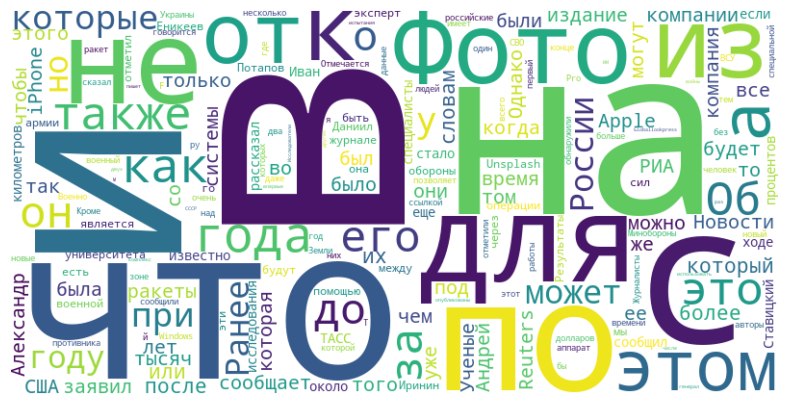

In [190]:
text_data_8 = " ".join(df[df.topic == 8]['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    collocations=False  
).generate(text_data_8)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

В целом новости по тематикам довольно-таки сильно различаются. Однако новости связанные с бывшим СССР и обществом весьма схожи, если судить по облакам слов. Это может создать некторые проблемы в ходе обучения моделей классификации.

In [199]:
df.to_csv('lenta_cutted.csv')